<a href="https://colab.research.google.com/github/hwangzie/Detect-Corner-Mark-on-Device-and-Image-Quality/blob/main/Corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data preparation

##Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## importing essential library

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os

##data preprocessing

In [3]:
# load the dir for labeling
data_dir = '/content/drive/MyDrive/Dataset_NBS'
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    class_names=['false', 'true'],
    batch_size=16,
    image_size=(224, 224),
    shuffle=True
)
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

Found 240 files belonging to 2 classes.


##take a look at the data

Labels: [[1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]]


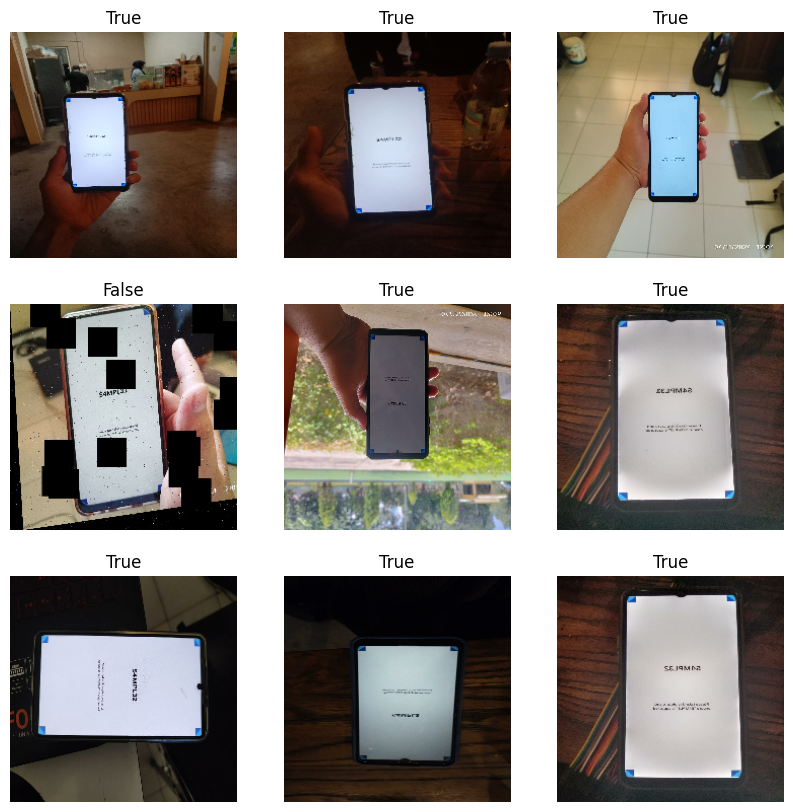

In [6]:
# Display one batch of images and labels
for images, labels in dataset.take(1):
    print("Labels:", labels.numpy())

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("False" if labels[i][0] < 0.5 else "True")
        plt.axis("off")
    plt.show()

#Model

##declare pretrained model


In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
)
base_model.trainable = False
layer_index = None
# for i, layer in enumerate(base_model.layers):
#     if layer.name == 'block_6_project_BN':
#         layer_index = i
#         break
# if layer_index is not None:
#     base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[layer_index].output)
#     base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##making the NN

In [8]:
model = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# callback if model reach 89 accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 89% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()


In [13]:
#resets the keras session avoiding memory overload
from IPython.display import clear_output
import gc
gc.collect()
tf.keras.backend.clear_session()
clear_output()

##training the model

In [14]:
history = model.fit(dataset, epochs=50, callbacks=[callbacks])

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.6078 - loss: 12.6704
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 407ms/step - accuracy: 0.7817 - loss: 11.9173
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.7827 - loss: 11.2345
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 408ms/step - accuracy: 0.8310 - loss: 10.5967
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.8455 - loss: 10.0947
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 397ms/step - accuracy: 0.8230 - loss: 9.5640
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 284ms/step - accuracy: 0.8371 - loss: 9.0845
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 340ms/step - accuracy: 0.8525 - loss: 8.5528
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 326ms/step - accuracy: 0.8978 - loss: 8.0566
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 349ms/step - accuracy: 0.8811 - loss: 7.6506
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 404ms/step - accuracy: 0.8862 - loss: 7.2265
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 285ms

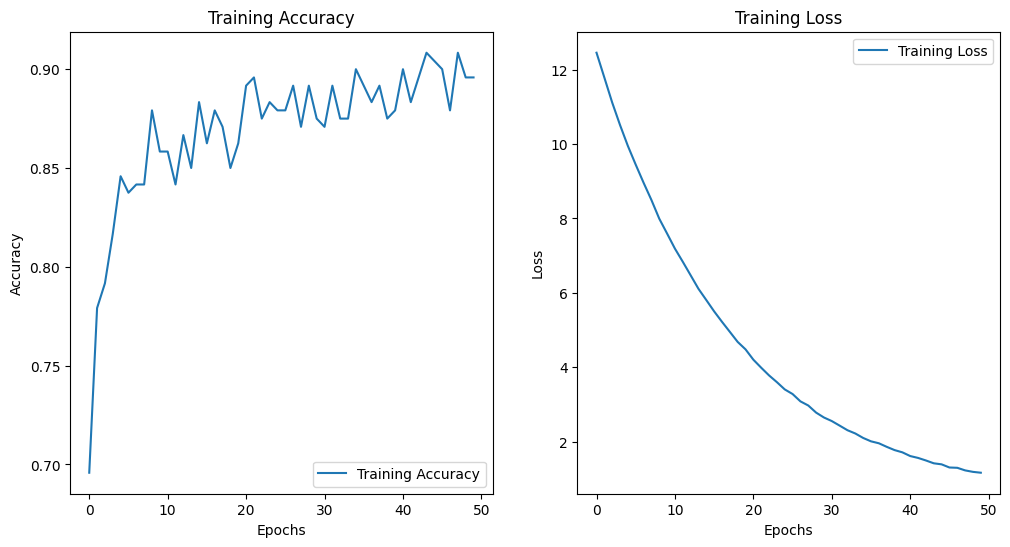

In [15]:
def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.show()
plot_training_history(history)

##testing the model with new data

In [ ]:
from PIL import Image
from tensorflow.keras.preprocessing import image
from io import BytesIO
import ipywidgets as widgets
from IPython.display import display

upload_button = widgets.FileUpload(accept='image/*', multiple=True)
display(upload_button)

def predict_uploaded_image(model, uploaded_file):
    img = Image.open(BytesIO(uploaded_file['content']))
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)

    if prediction[0] > 0.4:
        result = "Sesuai"
        print(f"Prediction score: {prediction[0]}")

    elif prediction[0] > 0.32:
        result = "Rekomendasikan untuk mengambil ulang"
        print(f"Prediction score: {prediction[0]}")

    else:
        result = "Tidak Sesuai"
        print(f"Prediction score: {prediction[0]}")

    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    print(f"Prediction result: {result}")
    return result

def on_upload_change(change):
    for uploaded_file in upload_button.value.values():
        # print(f"Processing file: {uploaded_file['name']}")
        predict_uploaded_image(model, uploaded_file)

upload_button.observe(on_upload_change, names='value')


#Convert the model

##importing essential lib

In [16]:
import pathlib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

## Convert the SavedModel to TFLite

In [17]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# dowload
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmppztmx3k5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_159')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138923132144272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923069689344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923130901024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923069688816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923066749904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923070796752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923066975936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923066976992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923066971184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138923066975760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389230669